In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from adjustText import adjust_text
import statsmodels.api as sm
from sklearn.decomposition import PCA
import umap.umap_ as umap
from sklearn.manifold import TSNE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from statsmodels.api import OLS
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Data Collection and Preprossecing

In [128]:
# Get data
communities_and_crime = fetch_ucirepo(id=183) 
X = communities_and_crime.data.features 
Y = communities_and_crime.data.targets 
X

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,?,0.02,0.12,0.45,?,?,?,?,0.00,?
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,?,0.01,0.21,0.02,?,?,?,?,0.00,?
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,?,0.02,0.39,0.28,?,?,?,?,0.00,?
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,?,0.04,0.09,0.02,?,?,?,?,0.00,?
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,?,?,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,?,0.01,0.28,0.05,?,?,?,?,0.00,?
1990,6,?,?,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,?,0.02,0.37,0.20,?,?,?,?,0.00,?
1991,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.25,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28
1992,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.19,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18


In [129]:
# Handling Missing Value
X = X.drop(columns=["state", "county", "community", "communityname", "fold"])
X = X.replace('?',np.nan)

label_encoder = LabelEncoder()
categorical_columns = X.select_dtypes(include=['object']).columns
for i in categorical_columns:
    X[i] = label_encoder.fit_transform(X[i])
X

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,29,0.12,0.26,0.20,6,4,62,1,0.32,14
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,77,0.02,0.12,0.45,63,38,72,3,0.00,51
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,77,0.01,0.21,0.02,63,38,72,3,0.00,51
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,77,0.02,0.39,0.28,63,38,72,3,0.00,51
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,77,0.04,0.09,0.02,63,38,72,3,0.00,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,77,0.01,0.28,0.05,63,38,72,3,0.00,51
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,77,0.02,0.37,0.20,63,38,72,3,0.00,51
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,25,0.08,0.32,0.18,8,6,50,0,0.91,28
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,19,0.03,0.38,0.33,2,2,51,0,0.22,18


In [130]:
# Standardization
scaler = StandardScaler(with_mean=True, with_std=True)
X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

colnames =X.columns

X_train, X_test, Y_train, Y_test = train_test_split(
    X_standardized, 
    Y, 
    test_size=0.2,      
    shuffle=True       
)

# EDA

In [ ]:
X_df = pd.DataFrame(X_standardized, columns=colnames)
Y_series = Y.values.flatten() if hasattr(Y, "values") else Y

# Pearson 线性相关性(Linear dependence)
pearson_corr = X_df.corrwith(pd.Series(Y_series))
pearson_corr_abs = pearson_corr.abs().sort_values(ascending=False)

# Mutual Information 非线性相关性(Non Linear dependence）
mi_scores = mutual_info_regression(X_df, Y_series, random_state=0)
mi_scores = pd.Series(mi_scores, index=X_df.columns).sort_values(ascending=False)

In [23]:
# 创建 DataFrame 汇总两个指标
correlation_table = pd.DataFrame({
    "Pearson": pearson_corr,                 # 原始线性相关系数（可正可负）
    "Pearson_abs": pearson_corr_abs,         # 绝对值，用于排名
    "Mutual_Info": mi_scores                 # 互信息分数（越高越重要）
})
# 根据任意一列排序，例如按 Pearson 绝对值排序
correlation_table_sorted = correlation_table.sort_values(by="Pearson_abs", ascending=False)

correlation_table_sorted.head(15)
#correlation_table_sorted.to_csv("correlation_table_sorted.csv", index=True)

,Pearson,Pearson_abs,Mutual_Info
PctKids2Par,-0.738424,0.738424,0.485357
PctIlleg,0.737957,0.737957,0.419211
PctFam2Par,-0.706667,0.706667,0.382812
racePctWhite,-0.684770,0.684770,0.339530
PctYoungKids2Par,-0.666059,0.666059,0.317417
PctTeen2Par,-0.661582,0.661582,0.326968
racepctblack,0.631264,0.631264,0.233133
pctWInvInc,-0.576324,0.576324,0.285995
pctWPubAsst,0.574665,0.574665,0.271814
FemalePctDiv,0.556032,0.556032,0.278966


In [ ]:
# 创建标签列：强 or 弱 相关变量 (if selected=1, strong feature)
correlation_table_labeled = correlation_table.copy()
correlation_table_labeled["Selected"] = (
    ~((correlation_table_labeled["Mutual_Info"] < 0.15) & 
      (correlation_table_labeled["Pearson_abs"] < 0.4))
).astype(int)  # 满足条件的记为 False，用 ~ 取反后转为 1/0

correlation_table_labeled.head(15)

,Pearson,Pearson_abs,Mutual_Info,Selected
AsianPerCap,-0.155592,0.155592,0.072634,0
FemalePctDiv,0.556032,0.556032,0.278966,1
HispPerCap,-0.244553,0.244553,0.060211,0
HousVacant,0.421396,0.421396,0.157662,1
LandArea,0.196800,0.196800,0.001733,0
LemasGangUnitDeploy,-0.330183,0.330183,0.104342,0
LemasPctOfficDrugUn,0.348627,0.348627,0.062080,0
LemasPctPolicOnPatr,-0.342092,0.342092,0.083848,0
LemasSwFTFieldOps,-0.398444,0.398444,0.109442,0
LemasSwFTFieldPerPop,-0.325302,0.325302,0.074517,0


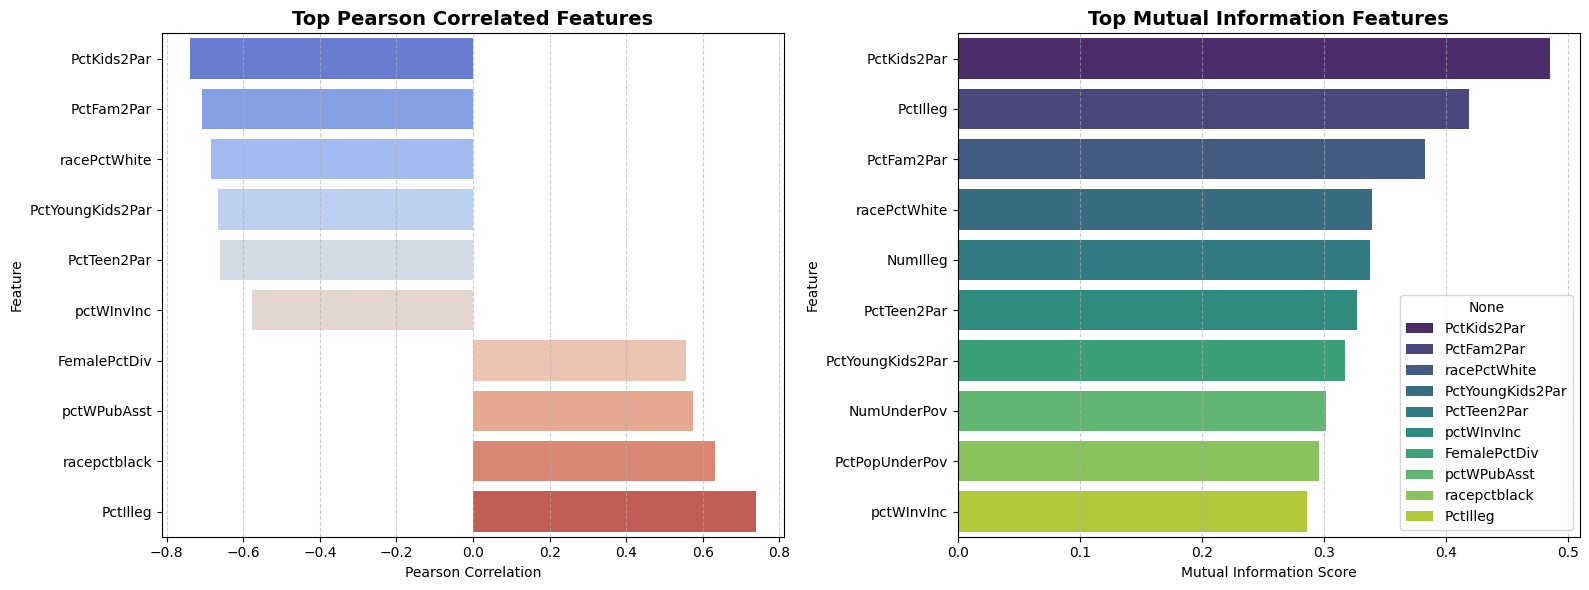

In [25]:
# 取 Top 10 变量
top_k = 10
top_pearson = pearson_corr.loc[pearson_corr_abs.head(top_k).index].sort_values()
top_mi = mi_scores.head(top_k)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 子图1：Pearson
sns.barplot(
    x=top_pearson.values,
    y=top_pearson.index,
    hue=top_pearson.index, 
    palette="coolwarm",
    legend=False,
    ax=axes[0]
)

axes[0].set_title("Top Pearson Correlated Features", fontsize=14, weight='bold')
axes[0].set_xlabel("Pearson Correlation")
axes[0].set_ylabel("Feature")
axes[0].grid(axis='x', linestyle='--', alpha=0.6)

# 子图2：Mutual Info
sns.barplot(
    x=top_mi.values,
    y=top_mi.index,
    hue=top_pearson.index,
    palette="viridis",
    ax=axes[1]
)
axes[1].set_title("Top Mutual Information Features", fontsize=14, weight='bold')
axes[1].set_xlabel("Mutual Information Score")
axes[1].set_ylabel("Feature")
axes[1].grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


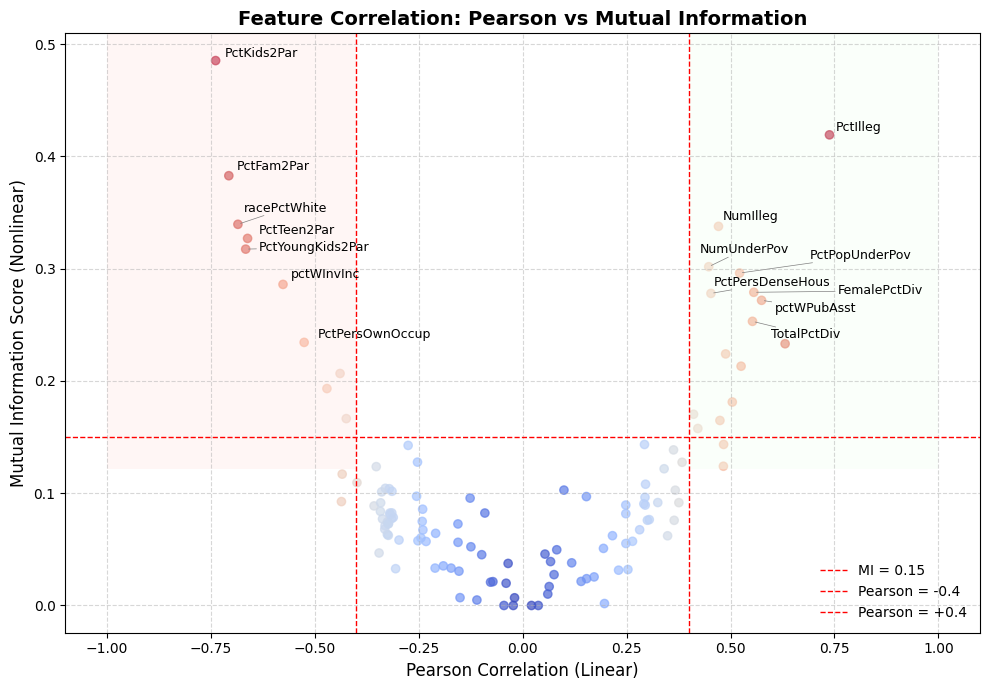

In [ ]:
plt.figure(figsize=(10, 7))

# 散点图
sc = plt.scatter(
    correlation_table["Pearson"],
    correlation_table["Mutual_Info"],
    alpha=0.7,
    c=correlation_table["Pearson_abs"],
    cmap="coolwarm"
)

# 标题和坐标轴
plt.title("Feature Correlation: Pearson vs Mutual Information", fontsize=14, weight='bold')
plt.xlabel("Pearson Correlation (Linear)", fontsize=12)
plt.ylabel("Mutual Information Score (Nonlinear)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# 背景色区域：左上（线性弱、非线性强）与右上（线性非线性都强）
plt.axvspan(xmin=-1, xmax=-0.4, ymin=0.15/0.55, ymax=1, facecolor='mistyrose', alpha=0.3)
plt.axvspan(xmin=0.4, xmax=1, ymin=0.15/0.55, ymax=1, facecolor='honeydew', alpha=0.3)

# 辅助线
plt.axhline(y=0.15, color='red', linestyle='--', linewidth=1, label='MI = 0.15')
plt.axvline(x=-0.4, color='red', linestyle='--', linewidth=1, label='Pearson = -0.4')
plt.axvline(x=0.4, color='red', linestyle='--', linewidth=1, label='Pearson = +0.4')

# 标注前15的变量
texts = []
top_features = correlation_table.sort_values("Mutual_Info", ascending=False).head(15).index
for feature in top_features:
    x = correlation_table.loc[feature, "Pearson"]
    y = correlation_table.loc[feature, "Mutual_Info"]
    texts.append(plt.text(x, y, feature, fontsize=9))

adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

plt.legend(loc='lower right', frameon=False)

plt.tight_layout()
plt.show()

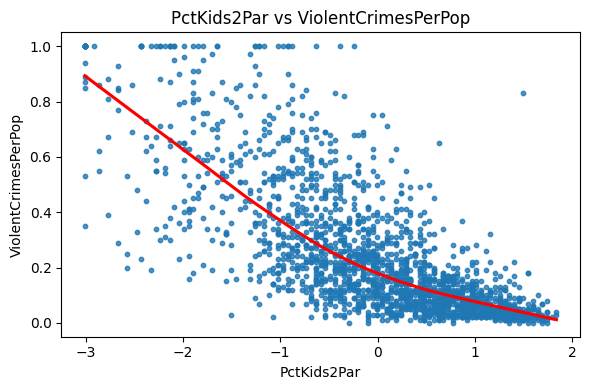

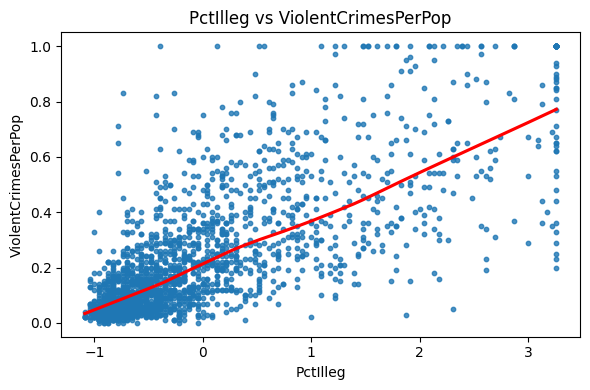

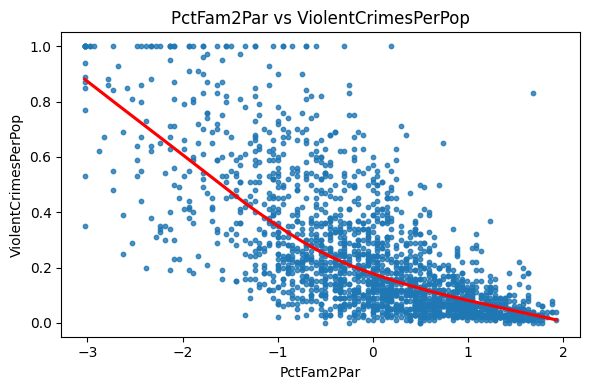

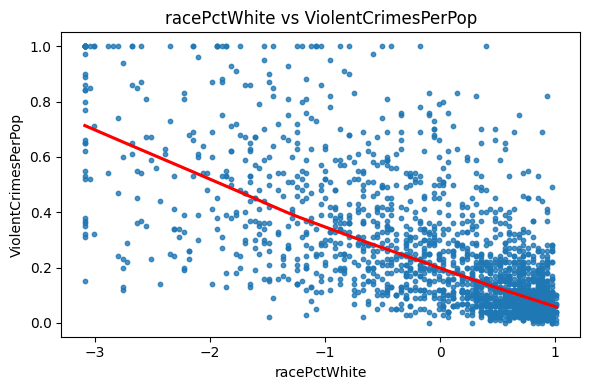

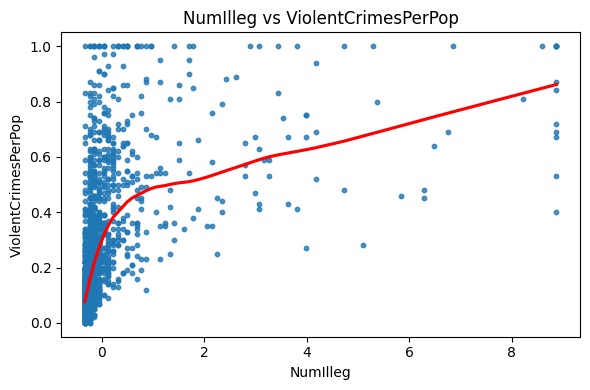

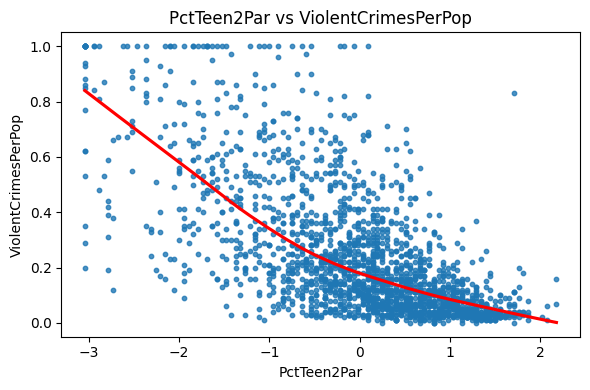

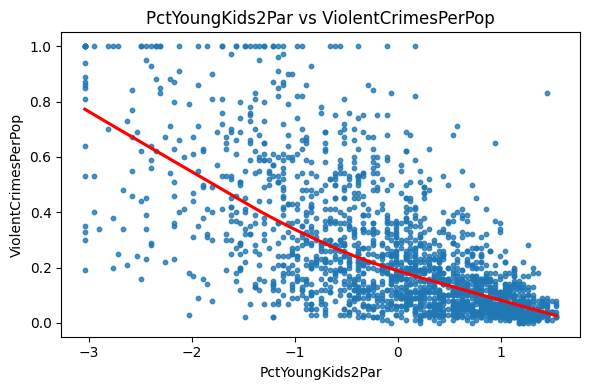

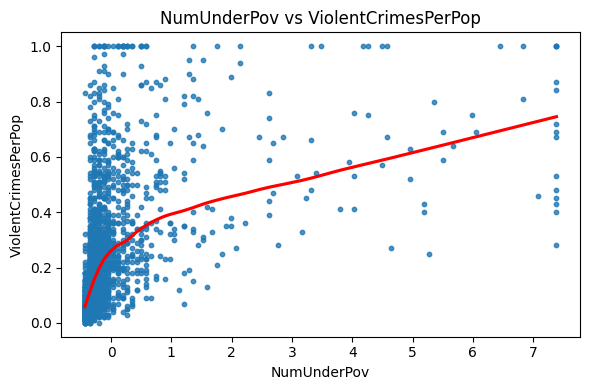

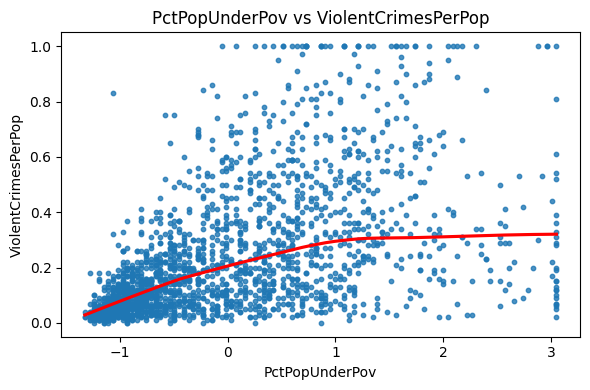

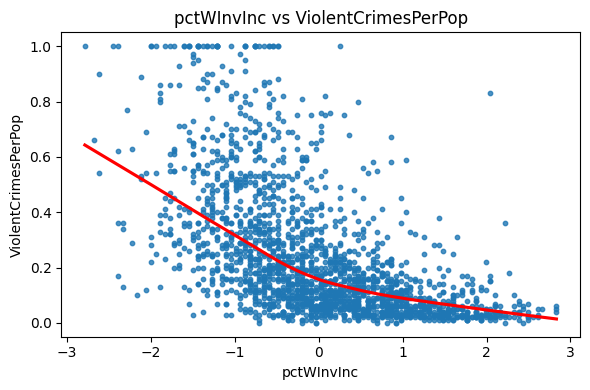

In [28]:
# 选出互信息排名前 top_k 个变量，绘制散点图看趋势
for feature in mi_scores.head(top_k).index:
    plt.figure(figsize=(6,4))
    sns.regplot(x=X_df[feature], y=Y_series, lowess=True, scatter_kws={"s":10}, line_kws={"color":"red"})
    plt.title(f"{feature} vs ViolentCrimesPerPop")
    plt.xlabel(feature)
    plt.ylabel("ViolentCrimesPerPop")
    plt.tight_layout()
    plt.show()

In [29]:
# 设定条件：|Pearson| > 0.4 或 Mutual_Info > 0.15
condition = (correlation_table["Pearson_abs"] > 0.4) | (correlation_table["Mutual_Info"] > 0.15)
correlation_selected = correlation_table[condition].copy()
selected_variable_names = correlation_selected.index.tolist()
print(selected_variable_names)

['FemalePctDiv', 'HousVacant', 'MalePctDivorce', 'NumIlleg', 'NumUnderPov', 'PctFam2Par', 'PctHousLess3BR', 'PctHousNoPhone', 'PctHousOwnOcc', 'PctIlleg', 'PctKids2Par', 'PctLess9thGrade', 'PctNotHSGrad', 'PctPersDenseHous', 'PctPersOwnOccup', 'PctPolicWhite', 'PctPopUnderPov', 'PctTeen2Par', 'PctUnemployed', 'PctVacantBoarded', 'PctYoungKids2Par', 'RacialMatchCommPol', 'TotalPctDiv', 'medFamInc', 'medIncome', 'pctWInvInc', 'pctWPubAsst', 'racePctWhite', 'racepctblack']


In [103]:
combined_variables = list(set(selected_variable_names) | set(forward_selected) | set(backward_selected))
X_selected = X_train[combined_variables]

In [104]:
X_selected

,PctUsePubTrans,LemasPctOfficDrugUn,PctLargHouseFam,pctWInvInc,PctKids2Par,PctLargHouseOccup,PolicBudgPerPop,LemasSwornFT,LemasGangUnitDeploy,MedRent,...,agePct12t29,numbUrban,PolicOperBudg,PctHousNoPhone,RacialMatchCommPol,pctWSocSec,pctWPubAsst,PctPolicWhite,PctVacantBoarded,whitePerCap
785,0.02,0.0,0.08,0.45,0.74,0.10,51,38,3,0.38,...,0.46,0.02,38,0.08,76,0.32,0.12,74,0.04,0.41
968,0.02,0.0,0.18,0.39,0.60,0.16,51,38,3,0.44,...,0.48,0.03,38,0.11,76,0.41,0.18,74,0.07,0.29
82,0.02,0.0,0.28,0.39,0.57,0.24,51,38,3,0.16,...,0.42,0.00,38,0.67,76,0.76,0.28,74,0.42,0.18
910,0.59,0.0,0.30,0.86,0.98,0.36,51,38,3,0.78,...,0.39,0.01,38,0.02,76,0.27,0.11,74,0.52,0.92
1732,0.00,0.0,0.36,0.35,0.54,0.34,51,38,3,0.20,...,0.51,0.00,38,0.86,76,0.36,0.36,74,0.20,0.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,0.00,0.0,0.07,0.61,0.43,0.07,51,38,3,0.33,...,0.18,0.03,38,0.37,76,1.00,0.35,74,0.03,0.33
1964,1.00,0.0,0.46,0.37,0.27,0.39,51,38,3,0.42,...,0.46,0.11,38,0.30,76,0.51,0.46,74,0.41,0.46
592,0.02,0.0,0.14,0.84,0.97,0.18,51,38,3,0.54,...,0.33,0.05,38,0.01,76,0.17,0.02,74,0.07,0.77
617,0.03,0.0,0.22,0.51,0.61,0.20,51,38,3,0.25,...,0.53,0.09,38,0.29,76,0.43,0.32,74,0.08,0.26


c:\Users\XiaoJingJing\Desktop\5243-Final-Pj\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


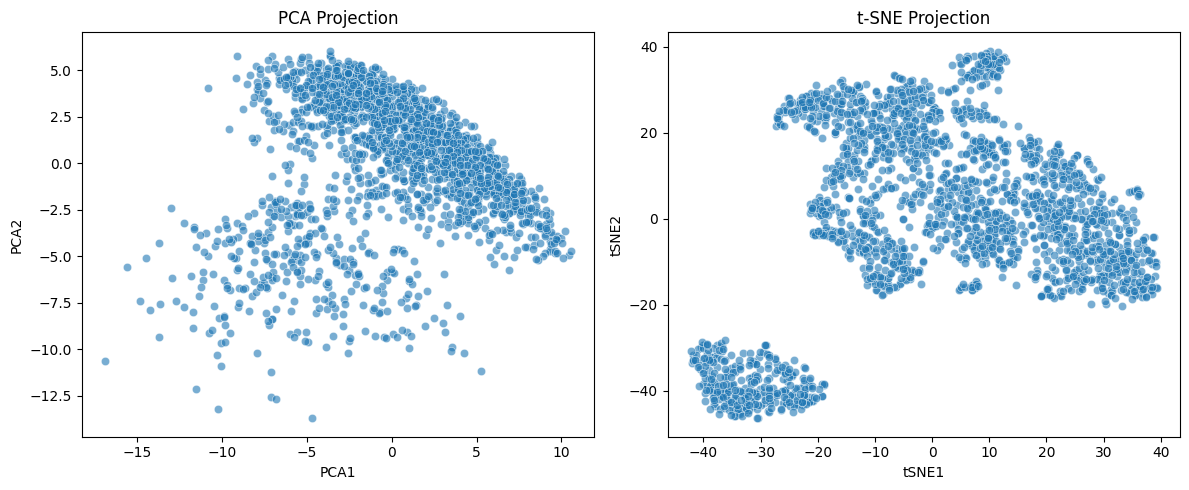

In [ ]:
# unsupervised learning
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# PCA 降维
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, columns=["PCA1", "PCA2"])
# t-SNE 降维
tsne = TSNE(n_components=2, perplexity=50, n_iter=2000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
X_tsne_df = pd.DataFrame(X_tsne, columns=["tSNE1", "tSNE2"])
# 可视化
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=X_pca_df, x="PCA1", y="PCA2", alpha=0.6)
plt.title("PCA Projection")
plt.subplot(1, 2, 2)
sns.scatterplot(data=X_tsne_df, x="tSNE1", y="tSNE2", alpha=0.6)
plt.title("t-SNE Projection")
plt.tight_layout()
plt.show()

c:\Users\XiaoJingJing\Desktop\5243-Final-Pj\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\XiaoJingJing\Desktop\5243-Final-Pj\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\XiaoJingJing\Desktop\5243-Final-Pj\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


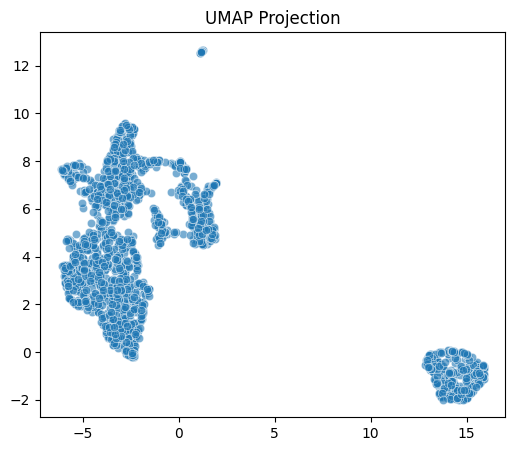

In [54]:
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

# 可视化
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], alpha=0.6)
plt.title("UMAP Projection")
plt.show()

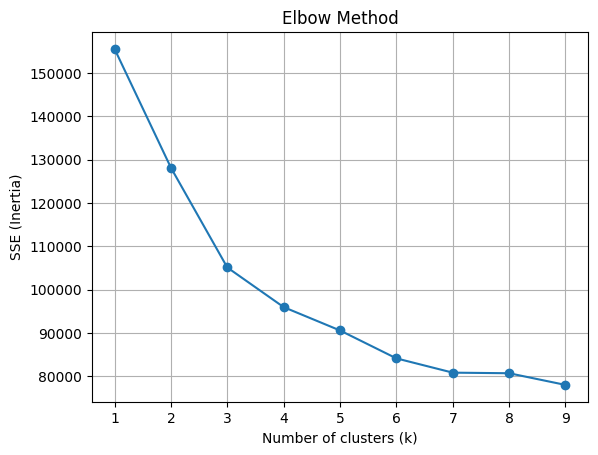

In [53]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []
K_range = range(1, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    sse.append(km.inertia_)  # inertia_ = 簇内误差平方和

plt.plot(K_range, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

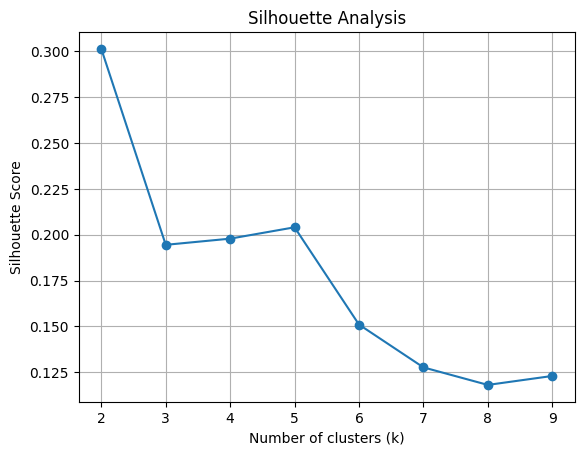

In [55]:
from sklearn.metrics import silhouette_score

scores = []
K_range = range(2, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    score = silhouette_score(X_scaled, km.labels_)
    scores.append(score)

plt.plot(K_range, scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.grid(True)
plt.show()

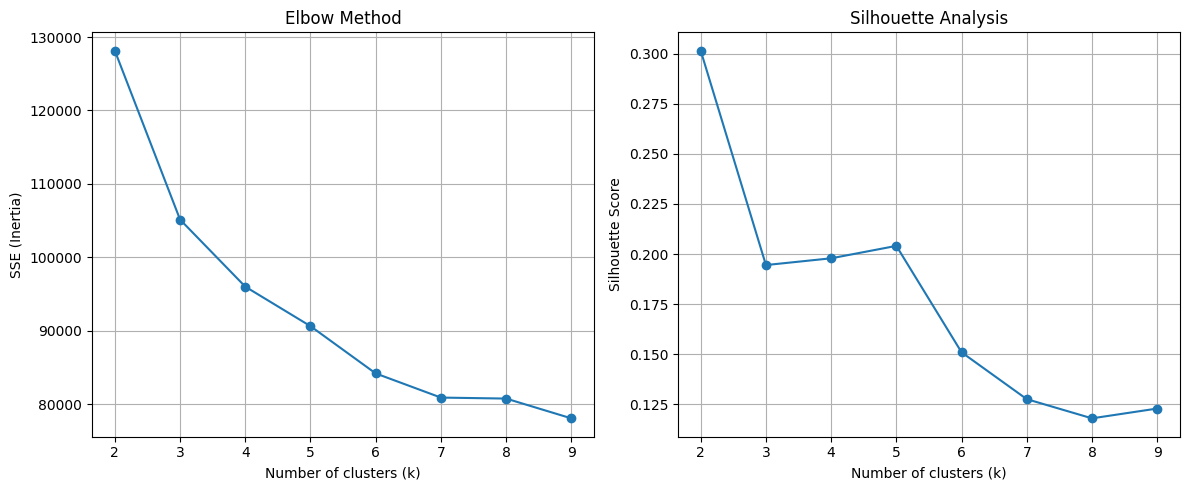

In [56]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

sse = []
silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    sse.append(km.inertia_)
    score = silhouette_score(X_scaled, km.labels_)
    silhouette_scores.append(score)

# 画图
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Elbow Method
axes[0].plot(K_range, sse, marker='o')
axes[0].set_xlabel('Number of clusters (k)')
axes[0].set_ylabel('SSE (Inertia)')
axes[0].set_title('Elbow Method')
axes[0].grid(True)

# Silhouette Score
axes[1].plot(K_range, silhouette_scores, marker='o')
axes[1].set_xlabel('Number of clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis')
axes[1].grid(True)

plt.tight_layout()
plt.show()


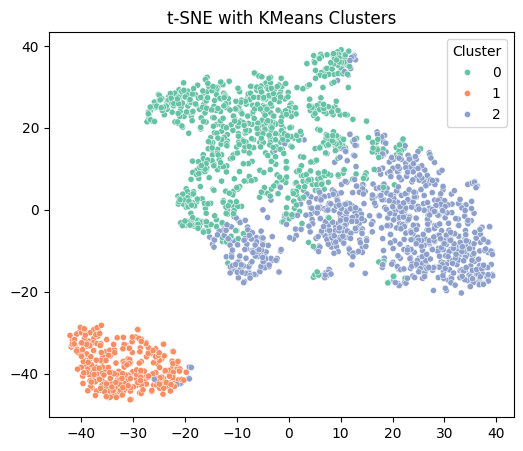

In [57]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# 在 t-SNE 图中可视化聚类
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette='Set2', s=20)
plt.title("t-SNE with KMeans Clusters")
plt.legend(title='Cluster')
plt.show()

In [58]:
X_selected['cluster'] = labels
cluster_summary = X_selected.groupby('cluster').mean().T
cluster_summary['std'] = cluster_summary.std(axis=1)
top_diff_vars = cluster_summary.sort_values(by='std', ascending=False).head(15)

C:\Users\XiaoJingJing\AppData\Local\Temp\ipykernel_21320\3204037799.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_selected['cluster'] = labels


In [59]:
cluster_summary

cluster,0,1,2,std
PctUsePubTrans,0.086946,0.299839,0.184747,0.106563
LemasPctOfficDrugUn,0.000000,0.593323,0.004252,0.341334
PctLargHouseFam,0.293353,0.340645,0.215618,0.063128
pctWInvInc,0.385868,0.423484,0.630059,0.131477
PctKids2Par,0.509353,0.456161,0.790188,0.179477
...,...,...,...,...
pctWSocSec,0.545365,0.454065,0.404358,0.071519
pctWPubAsst,0.446934,0.420871,0.153110,0.162639
PctPolicWhite,74.000000,46.745161,73.753828,15.665008
PctVacantBoarded,0.242335,0.369032,0.107279,0.130899


In [60]:
top_vars_per_cluster = {}

for c in cluster_summary.columns[:-1]:  # 排除 'std' 列
    sorted_vars = cluster_summary[c].sort_values(ascending=False).index.tolist()
    top_vars_per_cluster[c] = sorted_vars

# 示例：输出每一类的变量名（已排序）
for cluster_id, var_list in top_vars_per_cluster.items():
    print(f"Cluster {cluster_id} variables (sorted):")
    print(var_list)
    print()


Cluster 0 variables (sorted):
['RacialMatchCommPol', 'PolicReqPerOffic', 'PctPolicWhite', 'LemasTotReqPerPop', 'PolicPerPop', 'PolicBudgPerPop', 'PctPolicAsian', 'PolicOperBudg', 'LemasSwornFT', 'OfficAssgnDrugUnits', 'LemasGangUnitDeploy', 'racePctWhite', 'TotalPctDiv', 'PctHousLess3BR', 'FemalePctDiv', 'pctWSocSec', 'PctYoungKids2Par', 'MalePctDivorce', 'MedRentPctHousInc', 'agePct12t29', 'PctWorkMom', 'PctNotHSGrad', 'PctKids2Par', 'PctWorkMomYoungKids', 'PctTeen2Par', 'PctFam2Par', 'pctWRetire', 'agePct65up', 'PctHousOwnOcc', 'PctUnemployed', 'PctVacMore6Mos', 'PctPersOwnOccup', 'MedYrHousBuilt', 'PctPopUnderPov', 'pctWWage', 'pctUrban', 'pctWPubAsst', 'PersPerOwnOccHous', 'MalePctNevMarr', 'PctLess9thGrade', 'PersPerRentOccHous', 'PctHousNoPhone', 'PersPerOccupHous', 'PctEmplManu', 'MedOwnCostPctIncNoMtg', 'PctEmploy', 'pctWInvInc', 'MedOwnCostPctInc', 'pctWFarmSelf', 'PctIlleg', 'HispPerCap', 'PctLargHouseFam', 'PctLargHouseOccup', 'AsianPerCap', 'RentHighQ', 'PctBSorMore', 'whit

# Feature Engineering

In [131]:
# OLS（finding important feature）
model_OLS = OLS(Y,X).fit()
model_OLS.summary()
OLS_features = X.columns[model_OLS.pvalues < 0.05]
print(OLS_features)

Index(['racepctblack', 'pctUrban', 'pctWFarmSelf', 'pctWInvInc', 'pctWRetire',
       'whitePerCap', 'PctPopUnderPov', 'PctEmploy', 'PctEmplManu',
       'MalePctDivorce', 'MalePctNevMarr', 'PctWorkMom', 'PctIlleg',
       'NumImmig', 'PctNotSpeakEnglWell', 'PersPerOccupHous',
       'PersPerRentOccHous', 'PctPersDenseHous', 'PctHousLess3BR',
       'HousVacant', 'PctVacMore6Mos', 'RentLowQ', 'MedRent',
       'MedOwnCostPctIncNoMtg', 'NumStreet', 'PctForeignBorn', 'LemasSwornFT',
       'PolicOperBudg', 'PolicBudgPerPop'],
      dtype='object')


In [132]:
model_OLS = OLS(Y_train,X_train).fit()
model_OLS.summary()
OLS_features = X.columns[model_OLS.pvalues < 0.05]
print(OLS_features)

Index(['NumStreet'], dtype='object')


In [133]:
# Stepwise Forward Selection based on AIC
def calculate_aic(estimator, X, y):
    n, k = X.shape  
    y_pred = estimator.predict(X)
    residual_sum_of_squares = ((y - y_pred) ** 2).sum(axis=0).item()
    aic = n * np.log(residual_sum_of_squares / n) + 2 * k
    return -aic 

def aic_scorer_wrapper(estimator, X, y):
    estimator.fit(X, y)
    return calculate_aic(estimator, X, y)
    
ln = LinearRegression()

sfs_forward = SFS(
    ln,
    k_features='best',
    forward=True,
    floating=False,
    scoring=aic_scorer_wrapper,  
    cv=None
)

sfs_forward.fit(X_train,Y_train)

forward_selected = list(sfs_forward.k_feature_names_)
print("Selected features:", list(sfs_forward.k_feature_names_))

Selected features: ['population', 'racepctblack', 'racePctWhite', 'racePctHisp', 'agePct12t29', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWRetire', 'medFamInc', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'PctPopUnderPov', 'PctEmploy', 'PctEmplManu', 'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr', 'TotalPctDiv', 'PersPerFam', 'PctKids2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'PctIlleg', 'PctNotSpeakEnglWell', 'PersPerOccupHous', 'PersPerOwnOccHous', 'PersPerRentOccHous', 'PctPersOwnOccup', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded', 'PctVacMore6Mos', 'OwnOccLowQuart', 'RentLowQ', 'MedRent', 'MedOwnCostPctIncNoMtg', 'NumStreet', 'PctForeignBorn', 'LemasSwFTPerPop', 'LemasTotalReq', 'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol', 'PctPolicBlack', 'PctPolicAsian', 'OfficAssgnDrugUnits', 'PctUsePubTrans', 'PolicCars', 'LemasGangUnitDeploy', 'PolicBudgPerPop']


In [134]:
# Stepwise Backward Selection based on AIC
sfs_backward = SFS(
    ln,
    k_features='best',
    forward=False,
    floating=False,
    scoring=aic_scorer_wrapper,  
    cv=None
)

sfs_backward.fit(X_train, Y_train)

backward_selected =  list(sfs_backward.k_feature_names_)
print("Selected features:", list(sfs_backward.k_feature_names_))

Selected features: ['racepctblack', 'agePct12t29', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWRetire', 'medFamInc', 'whitePerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'PctPopUnderPov', 'PctEmploy', 'PctEmplManu', 'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr', 'TotalPctDiv', 'PctKids2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'PctIlleg', 'PctSpeakEnglOnly', 'PctNotSpeakEnglWell', 'PctLargHouseOccup', 'PersPerOccupHous', 'PersPerRentOccHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR', 'HousVacant', 'PctHousOwnOcc', 'PctVacantBoarded', 'PctVacMore6Mos', 'OwnOccLowQuart', 'RentLowQ', 'MedRent', 'MedOwnCostPctIncNoMtg', 'NumStreet', 'PctForeignBorn', 'LemasTotalReq', 'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol', 'PctPolicAsian', 'OfficAssgnDrugUnits', 'PctUsePubTrans', 'PolicCars', 'LemasGangUnitDeploy', 'PolicBudgPerPop']


In [135]:
#用 LASSO + CV 进行特征选择时，筛选标准是保留 L1 后系数非零的特征。
#L1 惩罚的稀疏性特性，让他在correlated group中倾向于只保留一个特征（偶尔不止一个）。
#不过保留哪个系数不稳定。并且它的筛选标准也不是基于特征的重要性。严格意义上不算筛选数据的手段，不过考虑到数据中存在correlate的数据。使用lasso是合理的
#CV是用来选择lamba的，避免惩罚太严重
y_train = Y_train.values.ravel()
lasso_cv = LassoCV(fit_intercept=False,max_iter=5000)
lasso_cv.fit(X_train, y_train)

index_lasso_cv = 0
features_cv = list()
features_value_cv = list()
for i in lasso_cv.coef_:
    if i != 0:
        features_cv.append(index_lasso_cv)
        features_value_cv.append(i)
    index_lasso_cv = index_lasso_cv +1
print(colnames[features_cv])
print(features_value_cv)

Index(['racepctblack', 'racePctWhite', 'pctUrban', 'pctWInvInc', 'OtherPerCap',
       'MalePctDivorce', 'PctKids2Par', 'PctWorkMom', 'PctIlleg',
       'PctPersDenseHous', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded',
       'MedOwnCostPctIncNoMtg', 'NumStreet', 'PctForeignBorn',
       'RacialMatchCommPol', 'PolicAveOTWorked'],
      dtype='object')
[np.float64(0.004937132288913019), np.float64(-0.03880716624895047), np.float64(0.004690931894843085), np.float64(-0.0011259464247671818), np.float64(0.005805395050706944), np.float64(0.021481812528429484), np.float64(-0.05598329810856252), np.float64(-0.005328320959229467), np.float64(0.048548370170272026), np.float64(0.014732207074815254), np.float64(0.017418277320030293), np.float64(-0.01219665338301514), np.float64(0.0004394719514186833), np.float64(-0.0009308326202016875), np.float64(0.010623527180724443), np.float64(0.0032015007628088876), np.float64(-0.01212283302214344), np.float64(-0.0002661334004117607)]


In [136]:
#ElasticNet+CV，筛选标准是保留 L1 + L2后系数非零的特征。
#和LASSO相比的优点可以在一定程度上避免被L1删除掉可能重要的特征
elasticNet_cv = ElasticNetCV(fit_intercept=False,max_iter=5000)
elasticNet_cv.fit(X_train, y_train)

index_elasticNet_cv = 0
features_cv_ela = list()
features_value_cv_ela = list()

for i in elasticNet_cv.coef_:
    if i != 0:
        features_cv_ela.append(index_elasticNet_cv)
        features_value_cv_ela.append(i)
    index_elasticNet_cv += 1  
    
print(X_train.columns[features_cv_ela])
print(features_value_cv_ela)

Index(['racepctblack', 'racePctWhite', 'pctUrban', 'pctWWage', 'pctWInvInc',
       'OtherPerCap', 'MalePctDivorce', 'PctKids2Par', 'PctWorkMom',
       'PctIlleg', 'PctPersDenseHous', 'HousVacant', 'PctHousOccup',
       'PctVacantBoarded', 'MedOwnCostPctIncNoMtg', 'NumStreet',
       'PctForeignBorn', 'RacialMatchCommPol', 'PolicAveOTWorked'],
      dtype='object')
[np.float64(0.007558803271284507), np.float64(-0.036584996702938556), np.float64(0.004598185575527334), np.float64(-8.983169392317085e-05), np.float64(-0.0019892799018175226), np.float64(0.005605302129950805), np.float64(0.021766086916723913), np.float64(-0.054272215156712975), np.float64(-0.005284064968888067), np.float64(0.04810703130955574), np.float64(0.015235371629160105), np.float64(0.017381681872338125), np.float64(-0.012100208149470808), np.float64(0.0008185811014436314), np.float64(-0.001045251945859724), np.float64(0.010619464865726298), np.float64(0.004093820531323707), np.float64(-0.012071902451675963), np.floa

In [32]:
#选择哪一个方法找出来的数据？
#稳定性验证 + 内部交叉验证
#进行internal split。把train set分成两组。第一组选择特征，第二组验证MSE。运行10次，查看MSE分布。（）
#解释一下我为什么linear regression我用了两个方法。因为我sm的OLS用习惯了，然后意识到OLS好像默认不给incertercept，想起来后换成了sklearn的

In [37]:
#全部封装进函数。我自己都记不清，我给变量取了那些名字了。
def feature_choose(n_repeats, X, Y):
    mse_results = {"Least Squares": [], "Lasso": [], "Elastic Net": [], "Forward Stepwise": [], "Backward Stepwise": []}
    y = np.ravel(Y)
    ln = LinearRegression()
    
    for _ in range(n_repeats):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)
        
        X_train_const = sm.add_constant(X_train)
        model_OLS = sm.OLS(y_train, X_train_const).fit()
        selected = model_OLS.pvalues[model_OLS.pvalues < 0.05].index
        selected = selected.drop('const', errors='ignore') 
        
        X_train_OLS = X_train[selected]
        X_test_OLS = X_test[selected]
        
        ln.fit(X_train_OLS, y_train)
        y_pred_OLS = ln.predict(X_test_OLS)
        mse_results["Least Squares"].append(mean_squared_error(y_test, y_pred_OLS))
        
        # Forward Stepwise
        sfs_forward = SFS(ln, 
                          k_features='best',
                          forward=True,
                          floating=False,
                          scoring=aic_scorer_wrapper, 
                          cv=None)
        sfs_forward.fit(X_train, y_train)
        forward_features = list(sfs_forward.k_feature_names_)
        
        X_train_forward = X_train[forward_features]
        X_test_forward = X_test[forward_features]
        
        ln.fit(X_train_forward, y_train)
        y_pred_forward = ln.predict(X_test_forward)
        mse_results["Forward Stepwise"].append(mean_squared_error(y_test, y_pred_forward))
        
        # Backward Stepwise
        sfs_backward = SFS(ln,
                           k_features='best',
                           forward=False,
                           floating=False,
                           scoring=aic_scorer_wrapper,
                           cv=None)
        sfs_backward.fit(X_train, y_train)
        backward_features = list(sfs_backward.k_feature_names_)
        
        X_train_backward = X_train[backward_features]
        X_test_backward = X_test[backward_features]
        
        ln.fit(X_train_backward, y_train)
        y_pred_backward = ln.predict(X_test_backward)
        mse_results["Backward Stepwise"].append(mean_squared_error(y_test, y_pred_backward))
        
        # Lasso
        lasso = LassoCV(alphas=np.logspace(-3, 3, 10), cv=5, max_iter=5000)
        lasso.fit(X_train, y_train)
        mse_results["Lasso"].append(mean_squared_error(y_test, lasso.predict(X_test)))
        
        # Elastic Net
        elastic_net = ElasticNetCV(alphas=np.logspace(-3, 3, 10), l1_ratio=np.linspace(0.1, 0.9, 5), cv=5, max_iter=5000)
        elastic_net.fit(X_train, y_train)
        mse_results["Elastic Net"].append(mean_squared_error(y_test, elastic_net.predict(X_test)))
    
    return mse_results

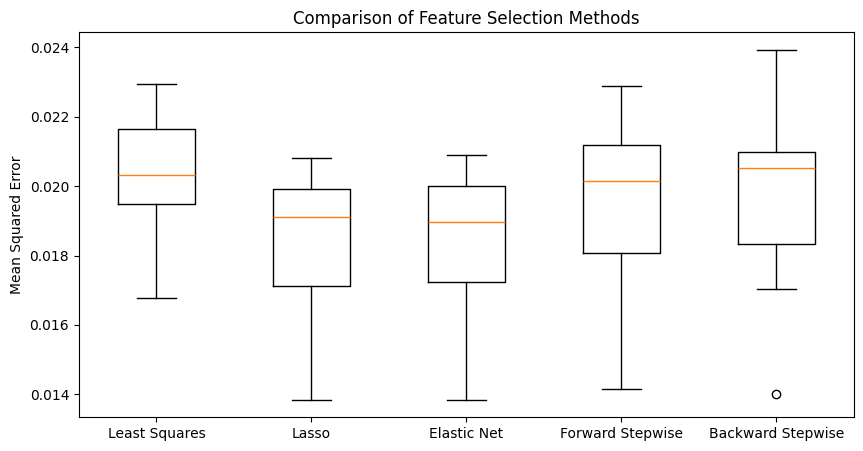

In [38]:
mse_results = feature_choose(n_repeats=10, X=X_train, Y=Y_train)

plt.figure(figsize=(10, 5))
plt.boxplot(mse_results.values(),tick_labels=mse_results.keys())
plt.ylabel("Mean Squared Error")
plt.title("Comparison of Feature Selection Methods")
plt.show()

# XG Boost and CatBoost

In [ ]:
#ViolentCrimesPerPop > 0.5 → label 1 (high‐violence), ≤ 0.5 → label 0 (low‐violence)
y_binary = (Y_series > 0.5).astype(int)

model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

# Fit on your PCA features + binary target
model.fit(X_pca, y_binary)

# Predict and evaluate
y_pred = model.predict(X_pca)
y_prob = model.predict_proba(X_pca)[:,1]

print("Accuracy :", accuracy_score(y_binary, y_pred))
print("ROC AUC  :", roc_auc_score(y_binary, y_prob))
print("\nClassification Report:\n", classification_report(y_binary, y_pred))

Accuracy : 0.9102306920762286
ROC AUC  : 0.9431076787865662

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95      1717
           1       0.77      0.51      0.61       277

    accuracy                           0.91      1994
   macro avg       0.85      0.74      0.78      1994
weighted avg       0.90      0.91      0.90      1994



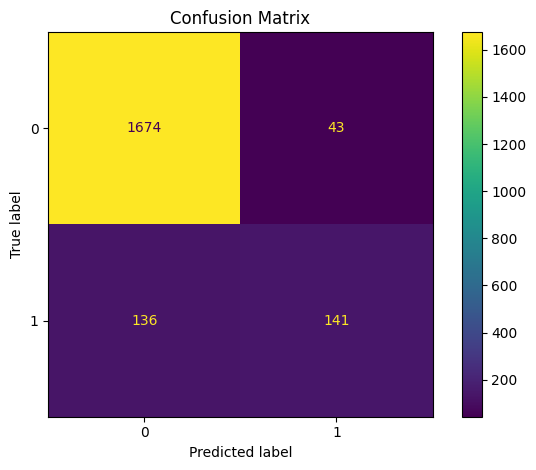

In [ ]:
# Generate predictions
y_pred = model.predict(X_pca)

# Compute the confusion matrix
cm = confusion_matrix(y_binary, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


From the result:

1. Strong at spotting safe areas: The XGBoost is good if our priority is not over-allocating resources to safe neighborhoods.

2. Weak at catching all hot spots: Only 48%  on high-violence means failing to indicate 1/2 of the areas that most need intervention

3. High ROC AUC but suboptimal threshold: AUC = 0.945 shows the model could separate classes well.

For better high-violence recall, we should adjust the decision cutoff.

Right now it's 0.5, we could choose a lower threshold (e.g. 0.2) to boost high-violence recall.

At 0.5 you get fairly few false alarms (FP = 35), but too many misses (FN = 145)



In [65]:
#Change the cutoff to 0.2
#ViolentCrimesPerPop > 0.2 → label 1 (high‐violence), ≤ 0.2 → label 0 (low‐violence)
y_binary1 = (Y_series > 0.2).astype(int)

model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

# Fit on your PCA features + binary target
model.fit(X_pca, y_binary1)

# Predict and evaluate
y_pred1 = model.predict(X_pca)
y_prob1 = model.predict_proba(X_pca)[:,1]

print("Accuracy :", accuracy_score(y_binary1, y_pred1))
print("ROC AUC  :", roc_auc_score(y_binary1, y_prob1))
print("\nClassification Report:\n", classification_report(y_binary1, y_pred1))

Accuracy : 0.8405215646940822
ROC AUC  : 0.9253990483829194

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1188
           1       0.83      0.76      0.79       806

    accuracy                           0.84      1994
   macro avg       0.84      0.83      0.83      1994
weighted avg       0.84      0.84      0.84      1994



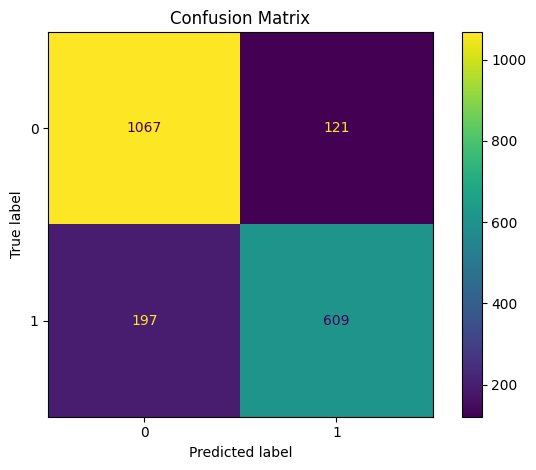

In [66]:
# Generate predictions
y_pred1 = model.predict(X_pca)

# Compute the confusion matrix
cm = confusion_matrix(y_binary1, y_pred1)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

After changing the cutoff to 0.2, the high_violence recall has been improved to 75%, and still maintain a 90% low-violence recall

In [97]:
! pip install catboost

   ---------------------------------------- 0.0/102.5 MB ? eta -:--:--
   ---------------------------------------- 0.2/102.5 MB 4.1 MB/s eta 0:00:25
   - -------------------------------------- 3.0/102.5 MB 31.4 MB/s eta 0:00:04
   -- ------------------------------------- 7.1/102.5 MB 50.0 MB/s eta 0:00:02
   ---- ----------------------------------- 12.5/102.5 MB 93.9 MB/s eta 0:00:01
   ------ -------------------------------- 17.8/102.5 MB 108.8 MB/s eta 0:00:01
   -------- ------------------------------ 23.1/102.5 MB 108.8 MB/s eta 0:00:01
   ---------- ---------------------------- 27.8/102.5 MB 108.8 MB/s eta 0:00:01
   ------------ --------------------------- 33.1/102.5 MB 93.9 MB/s eta 0:00:01
   -------------- ------------------------ 38.5/102.5 MB 131.2 MB/s eta 0:00:01
   ---------------- ---------------------- 43.4/102.5 MB 129.5 MB/s eta 0:00:01
   ------------------ -------------------- 48.9/102.5 MB 131.2 MB/s eta 0:00:01
   -------------------- ------------------ 54.3/102.5


[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\Users\XiaoJingJing\Desktop\5243-Final-Pj\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:14:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


==== XGBoost Results (Threshold = 0.45) ====
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       291
           1       0.80      0.72      0.76       108

    accuracy                           0.88       399
   macro avg       0.85      0.83      0.84       399
weighted avg       0.87      0.88      0.88       399

Confusion Matrix (XGBoost):
 [[272  19]
 [ 30  78]]
ROC AUC (XGBoost): 0.9218


==== CatBoost Results (Threshold = 0.45) ====
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       291
           1       0.80      0.75      0.78       108

    accuracy                           0.88       399
   macro avg       0.86      0.84      0.85       399
weighted avg       0.88      0.88      0.88       399

Confusion Matrix (CatBoost):
 [[271  20]
 [ 27  81]]
ROC AUC (CatBoost): 0.9279


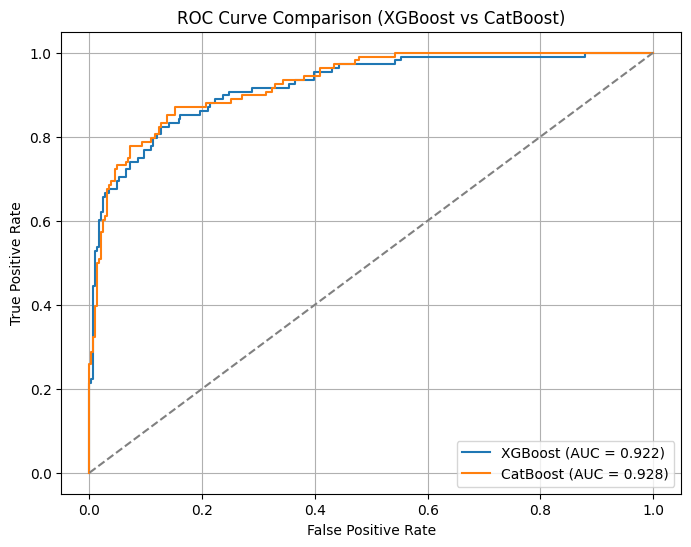

In [98]:
# --- 1. 导入必要的包 ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# --- 2. 数据划分 ---
# X_selected: 特征表
# y: 目标变量（0/1，高犯罪率）
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# --- 3. 建立XGBoost模型 ---
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    learning_rate=0.1,
    max_depth=6,
    n_estimators=300,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# --- 4. 建立CatBoost模型 ---
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    verbose=0,
    random_state=42
)
cat_model.fit(X_train, y_train)

# --- 5. 预测概率 ---
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_proba_cat = cat_model.predict_proba(X_test)[:, 1]

# --- 6. 按照0.45阈值分类 ---
threshold = 0.45

y_pred_xgb = (y_proba_xgb >= threshold).astype(int)
y_pred_cat = (y_proba_cat >= threshold).astype(int)

# --- 7. 评估XGBoost ---
print("==== XGBoost Results (Threshold = 0.45) ====")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix (XGBoost):\n", confusion_matrix(y_test, y_pred_xgb))
print(f"ROC AUC (XGBoost): {roc_auc_score(y_test, y_proba_xgb):.4f}")
print("\n")

# --- 8. 评估CatBoost ---
print("==== CatBoost Results (Threshold = 0.45) ====")
print(classification_report(y_test, y_pred_cat))
print("Confusion Matrix (CatBoost):\n", confusion_matrix(y_test, y_pred_cat))
print(f"ROC AUC (CatBoost): {roc_auc_score(y_test, y_proba_cat):.4f}")

# --- 9. 可选：绘制ROC曲线比较 ---
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
fpr_cat, tpr_cat, _ = roc_curve(y_test, y_proba_cat)

plt.figure(figsize=(8,6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_proba_xgb):.3f})')
plt.plot(fpr_cat, tpr_cat, label=f'CatBoost (AUC = {roc_auc_score(y_test, y_proba_cat):.3f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (XGBoost vs CatBoost)')
plt.legend()
plt.grid(True)
plt.show()


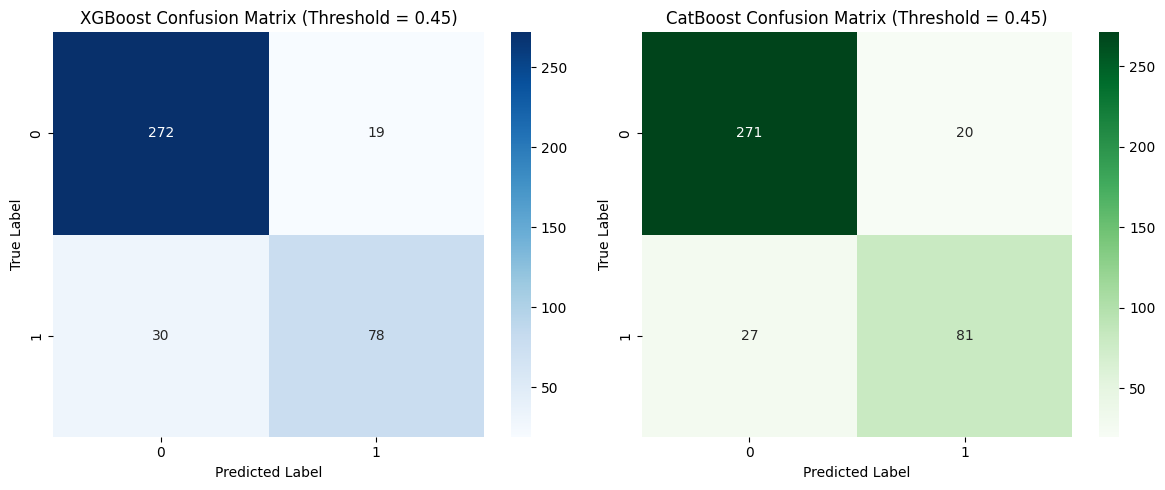

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# --- 计算混淆矩阵 ---
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
cm_cat = confusion_matrix(y_test, y_pred_cat)

# --- 绘制 ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 一行两列子图

# XGBoost混淆矩阵
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('XGBoost Confusion Matrix (Threshold = 0.45)')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# CatBoost混淆矩阵
sns.heatmap(cm_cat, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('CatBoost Confusion Matrix (Threshold = 0.45)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

# Models(logistic, random forest)

==== Logistic Regression Results ====
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       291
           1       0.85      0.71      0.77       108

    accuracy                           0.89       399
   macro avg       0.87      0.83      0.85       399
weighted avg       0.88      0.89      0.88       399

Confusion Matrix:
 [[277  14]
 [ 31  77]]
ROC AUC: 0.9289

==== Random Forest Results ====
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       291
           1       0.86      0.72      0.78       108

    accuracy                           0.89       399
   macro avg       0.88      0.84      0.86       399
weighted avg       0.89      0.89      0.89       399

Confusion Matrix:
 [[278  13]
 [ 30  78]]
ROC AUC: 0.9275


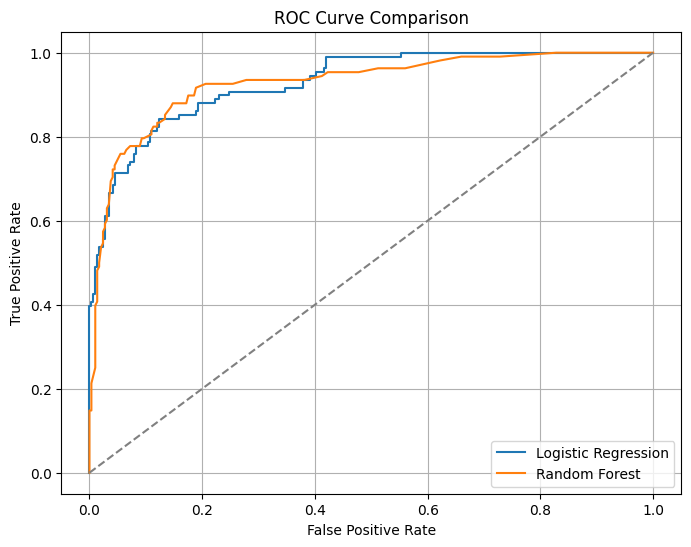

In [67]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# label
X = X_selected.copy()
y_continuous = Y['ViolentCrimesPerPop']
threshold = 0.3 
y = (y_continuous > threshold).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic回归建模
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train_scaled, y_train)

# Random Forest建模 
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)  # 注意RF可以直接用原始特征

# 预测 
y_pred_logistic = logistic_model.predict(X_test_scaled)
y_pred_rf = rf_model.predict(X_test)

# 评估结果
print("==== Logistic Regression Results ====")
print(classification_report(y_test, y_pred_logistic))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logistic))
print(f"ROC AUC: {roc_auc_score(y_test, logistic_model.predict_proba(X_test_scaled)[:,1]):.4f}")

print("\n==== Random Forest Results ====")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print(f"ROC AUC: {roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1]):.4f}")

# ROC曲线比较
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, logistic_model.predict_proba(X_test_scaled)[:,1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1])

plt.figure(figsize=(8,6))
plt.plot(fpr_logistic, tpr_logistic, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()


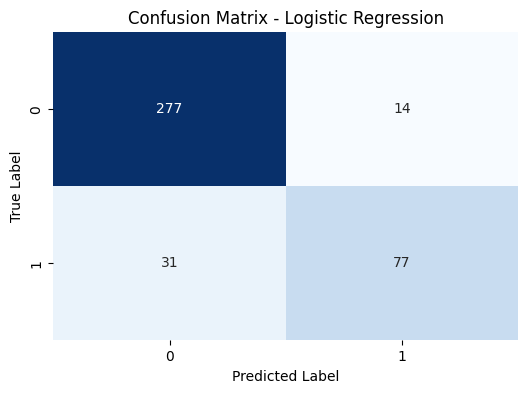

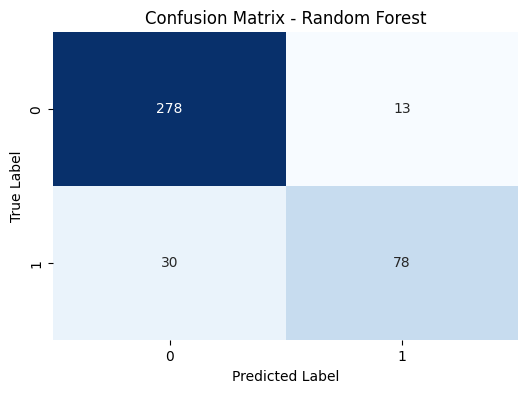

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve

# --- 1. 混淆矩阵热力图（以Logistic回归为例） ---
def plot_confusion_matrix_heatmap(y_true, y_pred, model_name="Model"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
# Logistic回归混淆矩阵
plot_confusion_matrix_heatmap(y_test, y_pred_logistic, model_name="Logistic Regression")
# Random Forest混淆矩阵
plot_confusion_matrix_heatmap(y_test, y_pred_rf, model_name="Random Forest")

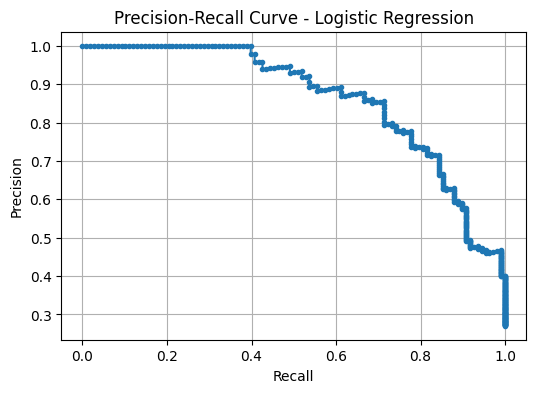

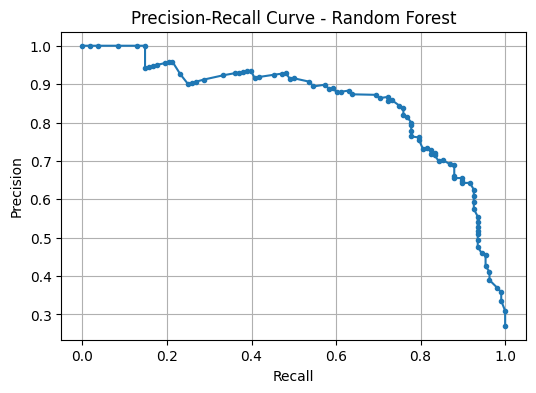

In [69]:
# --- 2. Precision-Recall曲线 ---
def plot_precision_recall(y_true, y_scores, model_name="Model"):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.grid(True)
    plt.show()

# Logistic回归PR曲线
plot_precision_recall(y_test, logistic_model.predict_proba(X_test_scaled)[:,1], model_name="Logistic Regression")

# Random Forest PR曲线
plot_precision_recall(y_test, rf_model.predict_proba(X_test)[:,1], model_name="Random Forest")

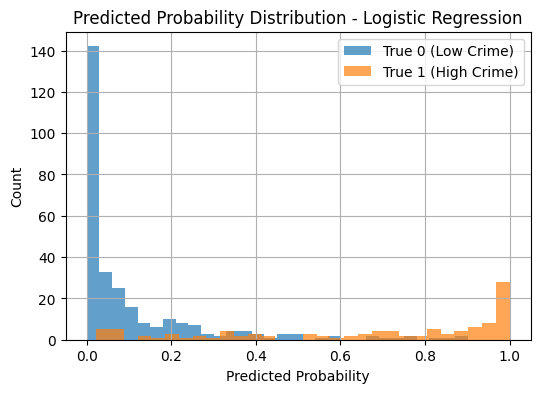

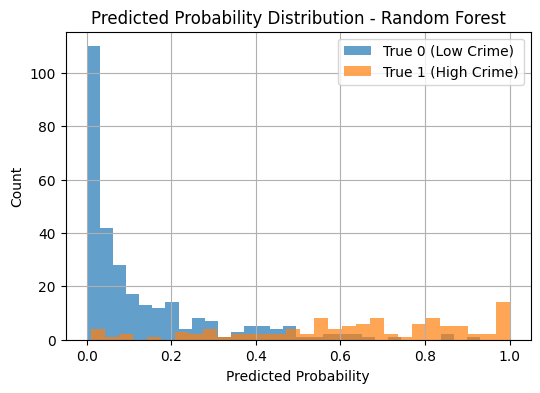

In [70]:
# --- 3. 预测概率分布直方图 ---
def plot_predicted_probability_distribution(y_true, y_scores, model_name="Model"):
    plt.figure(figsize=(6,4))
    plt.hist(y_scores[y_true==0], bins=30, alpha=0.7, label='True 0 (Low Crime)')
    plt.hist(y_scores[y_true==1], bins=30, alpha=0.7, label='True 1 (High Crime)')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Count')
    plt.title(f'Predicted Probability Distribution - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Logistic回归概率分布
plot_predicted_probability_distribution(y_test, logistic_model.predict_proba(X_test_scaled)[:,1], model_name="Logistic Regression")

# Random Forest概率分布
plot_predicted_probability_distribution(y_test, rf_model.predict_proba(X_test)[:,1], model_name="Random Forest")

In [79]:
# 重新划分训练测试集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# 重新建模
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# 拿到新的预测概率
y_scores = logistic_model.predict_proba(X_test)[:, 1]  # 注意这里[:, 1]是取正类的概率

c:\Users\XiaoJingJing\Desktop\5243-Final-Pj\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best threshold (max F1): 0.30


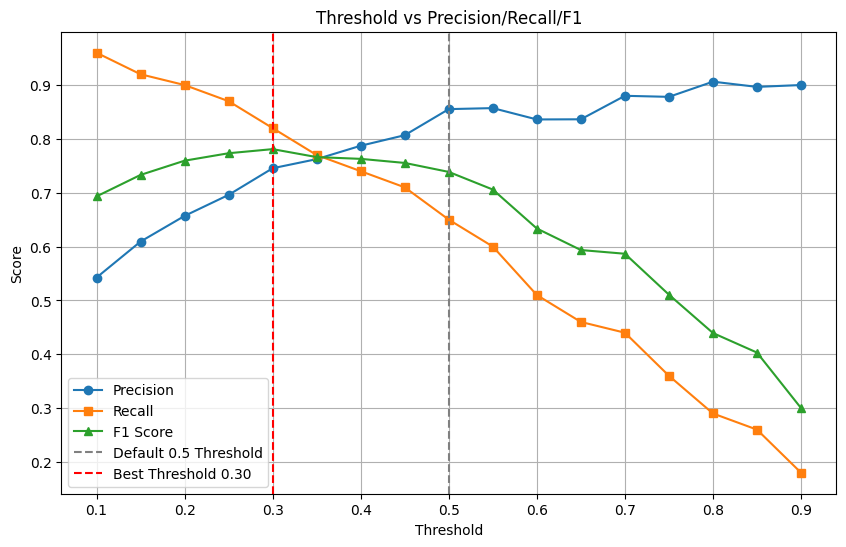

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Logistic Regression用默认的0.5做阈值

# --- 设定阈值范围 ---
thresholds = np.arange(0.1, 0.91, 0.05)

# --- 计算Precision/Recall/F1 ---
precisions, recalls, f1s = [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_scores >= thresh).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh))
    recalls.append(recall_score(y_test, y_pred_thresh))
    f1s.append(f1_score(y_test, y_pred_thresh))

# --- 找到F1-Score最大的阈值 ---
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
print(f"Best threshold (max F1): {best_threshold:.2f}")

# --- 绘制图形 ---
plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, marker='o', label='Precision')
plt.plot(thresholds, recalls, marker='s', label='Recall')
plt.plot(thresholds, f1s, marker='^', label='F1 Score')

# 标记默认0.5
plt.axvline(0.5, color='gray', linestyle='--', label='Default 0.5 Threshold')

# 标记自动选择的最优阈值
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold {best_threshold:.2f}')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold vs Precision/Recall/F1')
plt.legend()
plt.grid(True)
plt.show()


In [81]:
# logistic regression用0.3

threshold_for_classification = 0.3
y = (y_continuous > threshold_for_classification).astype(int)


# --- 3. 标准化 ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 4. 建立模型（Logistic回归） ---
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train_scaled, y_train)

# --- 5. 预测概率 ---
y_scores_logistic = logistic_model.predict_proba(X_test_scaled)[:, 1]

# --- 6. 使用自定义阈值做预测（不是默认0.5） ---
best_threshold = 0.25  
y_pred_custom = (y_scores_logistic >= best_threshold).astype(int)

Performance with threshold 0.25:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       299
           1       0.73      0.85      0.78       100

    accuracy                           0.88       399
   macro avg       0.84      0.87      0.85       399
weighted avg       0.89      0.88      0.89       399

Confusion Matrix:
 [[267  32]
 [ 15  85]]
ROC AUC: 0.9432


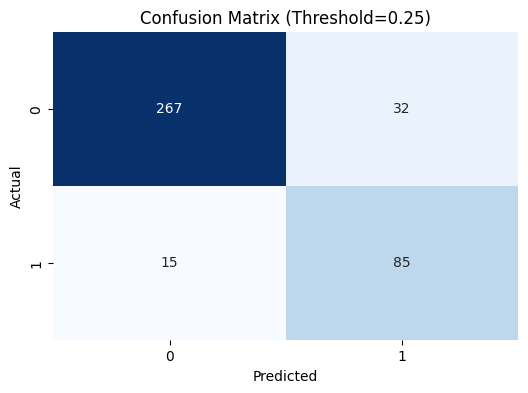

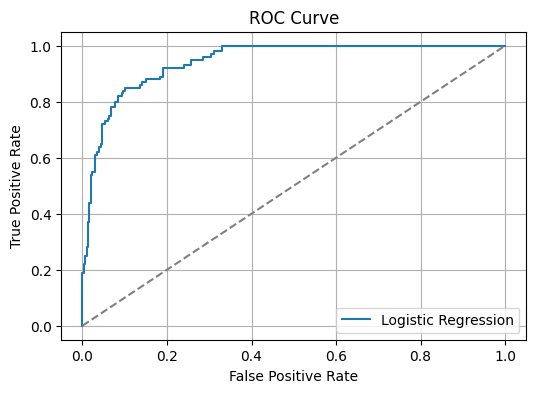

In [82]:
from sklearn.metrics import precision_score, recall_score, f1_score

# --- 1. 打印性能指标 ---
print(f"Performance with threshold {best_threshold:.2f}:")
print(classification_report(y_test, y_pred_custom))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom))
print(f"ROC AUC: {roc_auc_score(y_test, y_scores_logistic):.4f}")  # 注意ROC AUC还是用原始分数算，不受阈值影响

# --- 2. 混淆矩阵可视化 ---
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_custom)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.title(f"Confusion Matrix (Threshold={best_threshold:.2f})")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- 3. ROC曲线绘制 ---
fpr, tpr, _ = roc_curve(y_test, y_scores_logistic)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


Best threshold for Random Forest (max F1): 0.50


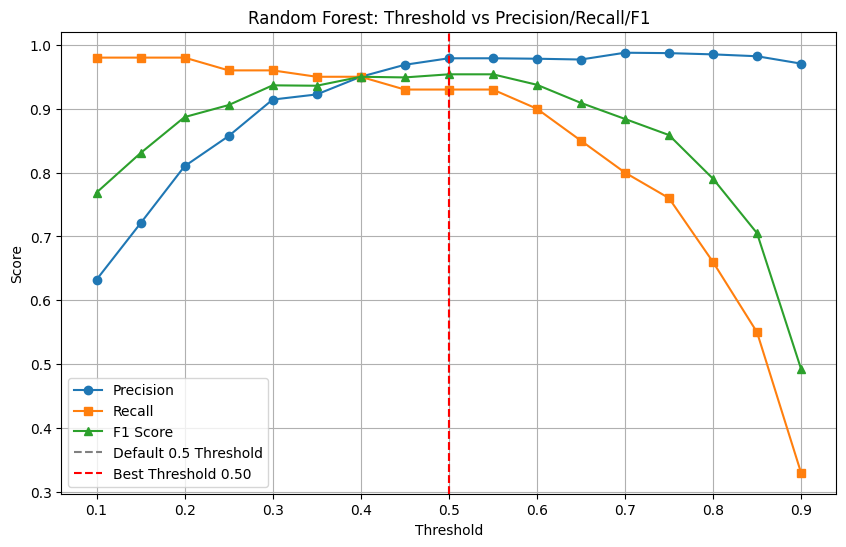

In [83]:
# find best threshhold for random forest

# --- 1. 获取Random Forest的预测概率 ---
y_scores_rf = rf_model.predict_proba(X_test)[:, 1]  # 注意是[:,1]拿正类（高犯罪区）的概率

# --- 2. 设置阈值范围 ---
thresholds = np.arange(0.1, 0.91, 0.05)  # 从0.1到0.9，每隔0.05

# --- 3. 计算每个阈值下的Precision, Recall, F1 ---
precisions = []
recalls = []
f1s = []

for thresh in thresholds:
    y_pred_thresh = (y_scores_rf >= thresh).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh))
    recalls.append(recall_score(y_test, y_pred_thresh))
    f1s.append(f1_score(y_test, y_pred_thresh))

# --- 4. 找到F1最高对应的阈值 ---
best_idx = np.argmax(f1s)
best_threshold_rf = thresholds[best_idx]
print(f"Best threshold for Random Forest (max F1): {best_threshold_rf:.2f}")

# --- 5. 画图 ---
plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, marker='o', label='Precision')
plt.plot(thresholds, recalls, marker='s', label='Recall')
plt.plot(thresholds, f1s, marker='^', label='F1 Score')

# --- 标注 ---
plt.axvline(0.5, color='gray', linestyle='--', label='Default 0.5 Threshold')
plt.axvline(best_threshold_rf, color='red', linestyle='--', label=f'Best Threshold {best_threshold_rf:.2f}')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Random Forest: Threshold vs Precision/Recall/F1')
plt.legend()
plt.grid(True)
plt.show()


In [84]:
# --- 4. 建立Random Forest模型 ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# --- 5. 预测概率 ---
y_scores_rf = rf_model.predict_proba(X_test)[:, 1]

# --- 6. 自定义阈值分类 ---
custom_threshold_rf = 0.45
y_pred_rf_custom = (y_scores_rf >= custom_threshold_rf).astype(int)

Random Forest Performance with threshold 0.45:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       299
           1       0.82      0.72      0.77       100

    accuracy                           0.89       399
   macro avg       0.86      0.83      0.85       399
weighted avg       0.89      0.89      0.89       399

Confusion Matrix:
 [[283  16]
 [ 28  72]]
ROC AUC: 0.9198


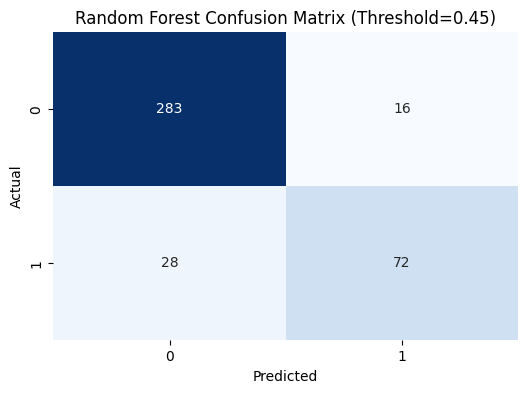

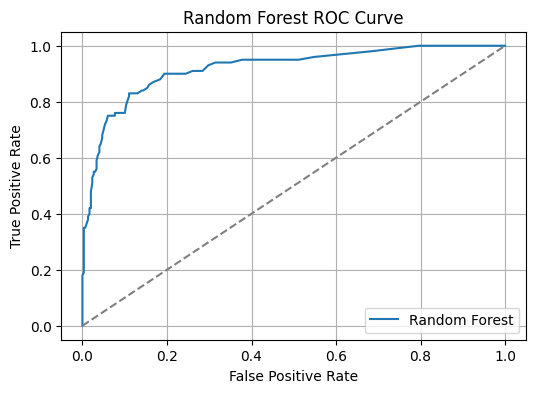

In [85]:
# --- 7. 评估结果 ---
print(f"Random Forest Performance with threshold {custom_threshold_rf:.2f}:")
print(classification_report(y_test, y_pred_rf_custom))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_custom))
print(f"ROC AUC: {roc_auc_score(y_test, y_scores_rf):.4f}")  # 注意ROC AUC还是用原始分数算

# --- 8. 混淆矩阵可视化 ---
cm_rf = confusion_matrix(y_test, y_pred_rf_custom)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.title(f"Random Forest Confusion Matrix (Threshold={custom_threshold_rf:.2f})")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- 9. ROC曲线绘制 ---
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_scores_rf)
plt.figure(figsize=(6,4))
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

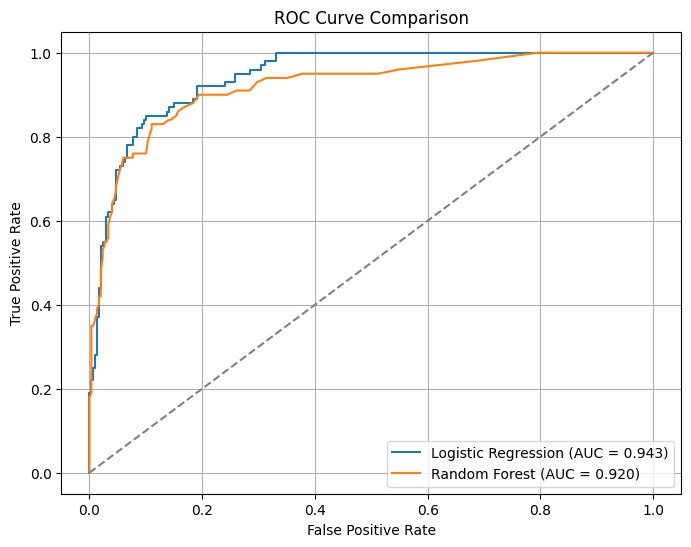

In [86]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# --- 1. 获取每个模型的预测概率 ---
# 假设你已经有
# y_scores_logistic = logistic_model.predict_proba(X_test_scaled)[:, 1]
# y_scores_rf = rf_model.predict_proba(X_test)[:, 1]

# --- 2. 分别计算ROC曲线坐标 ---
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_scores_logistic)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_scores_rf)

# --- 3. 绘制在同一张图上 ---
plt.figure(figsize=(8,6))
plt.plot(fpr_logistic, tpr_logistic, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_scores_logistic):.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_scores_rf):.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

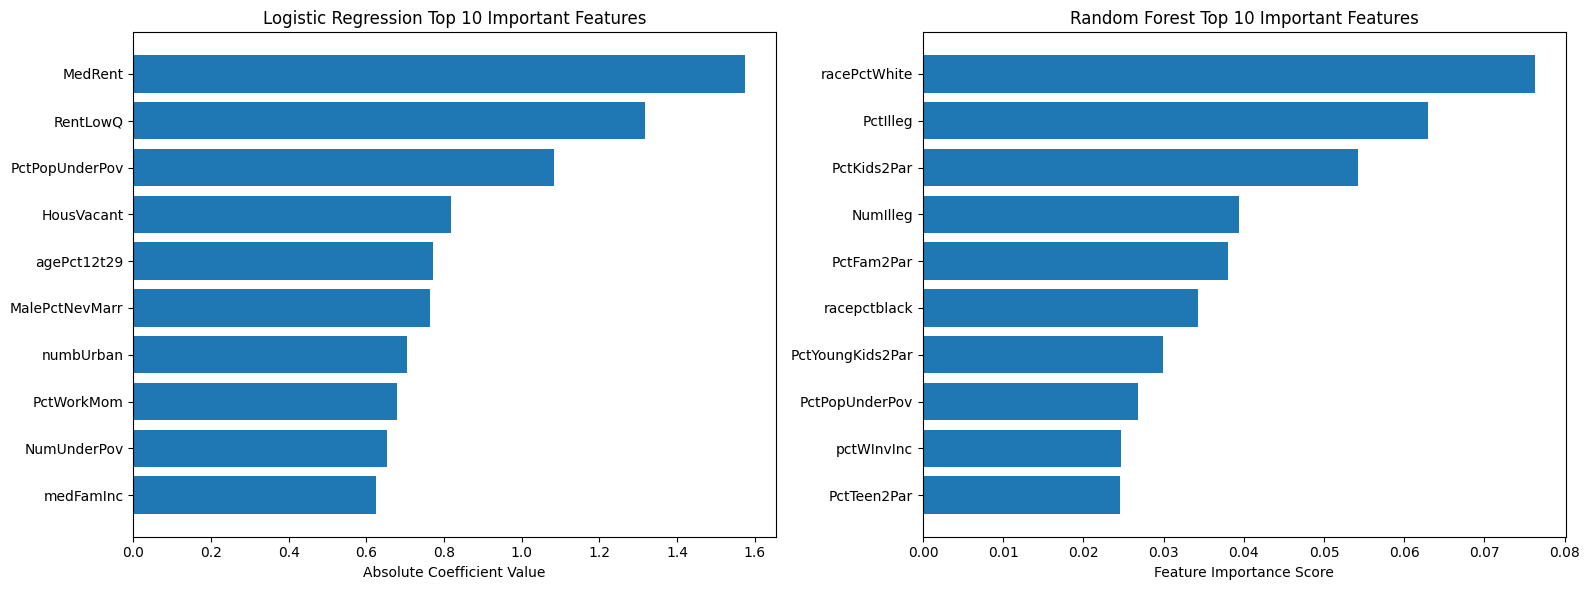

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Logistic回归的特征重要性=系数绝对值
coef_logistic = pd.Series(np.abs(logistic_model.coef_[0]), index=X_selected.columns)
coef_logistic_top10 = coef_logistic.sort_values(ascending=False).head(10)

-# RF的特征重要性=feature_importances_
importance_rf = pd.Series(rf_model.feature_importances_, index=X_selected.columns)
importance_rf_top10 = importance_rf.sort_values(ascending=False).head(10)

fig, axes = plt.subplots(1, 2, figsize=(16,6))

# Logistic回归Top10
axes[0].barh(coef_logistic_top10.index[::-1], coef_logistic_top10.values[::-1])  # 逆序画成从大到小
axes[0].set_title('Logistic Regression Top 10 Important Features')
axes[0].set_xlabel('Absolute Coefficient Value')

# Random Forest Top10
axes[1].barh(importance_rf_top10.index[::-1], importance_rf_top10.values[::-1])
axes[1].set_title('Random Forest Top 10 Important Features')
axes[1].set_xlabel('Feature Importance Score')

plt.tight_layout()
plt.show()


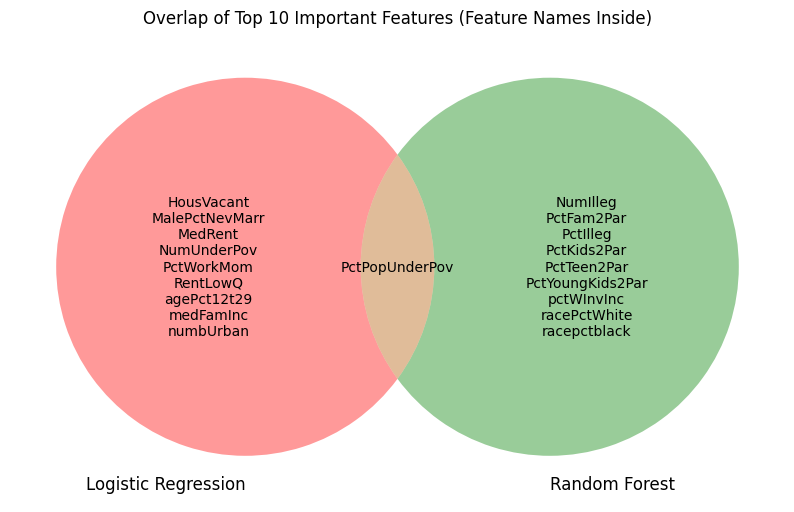

In [91]:
from matplotlib_venn import venn2

coef_logistic = pd.Series(np.abs(logistic_model.coef_[0]), index=X_selected.columns)
importance_rf = pd.Series(rf_model.feature_importances_, index=X_selected.columns)

# top 10 important features
top10_logistic = coef_logistic.sort_values(ascending=False).head(10)
top10_rf = importance_rf.sort_values(ascending=False).head(10)

set_logistic = set(top10_logistic.index)
set_rf = set(top10_rf.index)

plt.figure(figsize=(10,8))
venn = venn2([set_logistic, set_rf], set_labels=('Logistic Regression', 'Random Forest'))

# Logistic独有
if venn.get_label_by_id('10'):
    venn.get_label_by_id('10').set_text('\n'.join(sorted(set_logistic - set_rf)))

# Random Forest独有
if venn.get_label_by_id('01'):
    venn.get_label_by_id('01').set_text('\n'.join(sorted(set_rf - set_logistic)))

# 两边共有
if venn.get_label_by_id('11'):
    venn.get_label_by_id('11').set_text('\n'.join(sorted(set_logistic & set_rf)))

plt.title('Overlap of Top 10 Important Features (Feature Names Inside)')
plt.show()


c:\Users\XiaoJingJing\Desktop\5243-Final-Pj\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


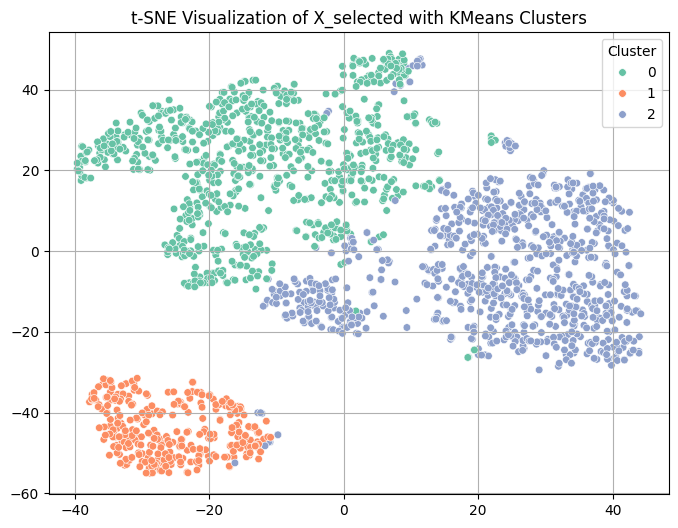

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# --- 1. 标准化 ---
scaler = StandardScaler()
X_selected_scaled = scaler.fit_transform(X_selected)

# --- 2. KMeans聚类 ---
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_selected_scaled)

# --- 3. t-SNE降维 ---
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_selected_tsne = tsne.fit_transform(X_selected_scaled)

# --- 4. 绘制t-SNE聚类结果 ---
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_selected_tsne[:,0], y=X_selected_tsne[:,1], hue=cluster_labels, palette='Set2', s=30)
plt.title('t-SNE Visualization of X_selected with KMeans Clusters')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [93]:
# 复制一份X_selected
X_labeled = X_selected.copy()

# 添加一列叫'cluster_label'
X_labeled['cluster_label'] = cluster_labels

# 展示一下结果
X_labeled.head()


,PctUsePubTrans,LemasPctOfficDrugUn,PctLargHouseFam,pctWInvInc,PctKids2Par,PctLargHouseOccup,PolicBudgPerPop,LemasSwornFT,LemasGangUnitDeploy,MedRent,...,PolicOperBudg,PctHousNoPhone,RacialMatchCommPol,pctWSocSec,pctWPubAsst,PctPolicWhite,PctVacantBoarded,whitePerCap,cluster,cluster_label
0,0.20,0.32,0.14,0.60,0.59,0.13,14,3,1,0.34,...,4,0.14,69,0.29,0.15,66,0.05,0.39,1,1
1,0.45,0.00,0.16,0.45,0.47,0.10,51,38,3,0.37,...,38,0.16,76,0.25,0.29,74,0.02,0.38,0,0
2,0.02,0.00,0.20,0.39,0.44,0.20,51,38,3,0.31,...,38,0.47,76,0.38,0.40,74,0.29,0.29,0,0
3,0.28,0.00,0.56,0.43,0.54,0.62,51,38,3,0.89,...,38,0.11,76,0.36,0.20,74,0.60,0.40,2,2
4,0.02,0.00,0.16,0.68,0.91,0.19,51,38,3,0.38,...,38,0.05,76,0.44,0.11,74,0.04,0.41,2,2


In [94]:
# 按照 cluster_label 分组并计算均值
cluster_summary = X_labeled.groupby('cluster_label').mean().T  # 注意.T是转置！
# 可选：加上每列的标准差
cluster_summary['std'] = X_labeled.drop(columns='cluster_label').std()
# 展示结果
cluster_summary

cluster_label,0,1,2,std
PctUsePubTrans,0.086946,0.299839,0.184747,0.229055
LemasPctOfficDrugUn,0.000000,0.593323,0.004252,0.240328
PctLargHouseFam,0.293353,0.340645,0.215618,0.196567
pctWInvInc,0.385868,0.423484,0.630059,0.178071
PctKids2Par,0.509353,0.456161,0.790188,0.206353
...,...,...,...,...
pctWPubAsst,0.446934,0.420871,0.153110,0.222137
PctPolicWhite,74.000000,46.745161,73.753828,12.543887
PctVacantBoarded,0.242335,0.369032,0.107279,0.217770
whitePerCap,0.246850,0.372677,0.485559,0.186804


In [95]:
# 1. 合并 X_labeled 和 Y
XY_labeled = X_labeled.copy()
XY_labeled['ViolentCrimesPerPop'] = Y.values.flatten()  # 保证是一维加进去
# 2. 按 cluster_label 分组，统计 summary
cluster_summary_y = XY_labeled.groupby('cluster_label').agg({
    'ViolentCrimesPerPop': ['mean', 'std', 'min', 'max']
})
# 3. 展示结果
cluster_summary_y

ViolentCrimesPerPop                      
                             mean       std   min   max
cluster_label                                          
0                        0.290647  0.233674  0.00  1.00
1                        0.451871  0.273808  0.02  1.00
2                        0.108080  0.101022  0.00  0.83

# Model COmparision

In [137]:
#从图片可以看出elasticNet选择的数据最好，那么之后会用它选择的数据来建模
selected_columns = X_train.columns[features_cv_ela]  
X_selected = X_train[selected_columns]  
X_test = X_test[selected_columns]

In [138]:
#写一个自动衡量模型参数的def
def model_score(X, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    n = X.shape[0]
    p = X.shape[1]
    r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)

        
    
    return {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "Adjusted R2": r2_adj
    }

In [139]:
#Lasso
lasso = LassoCV(alphas=np.logspace(-3, 3, 10), cv=5, max_iter=5000)
lasso.fit(X_selected, y_train)
model_score(X_selected,Y_test,lasso.predict(X_test))

{'MSE': 0.017546014000234485,
 'RMSE': np.float64(0.13246136795396038),
 'MAE': 0.09431802087909254,
 'R2': 0.6477119480966812,
 'Adjusted R2': 0.6434621239784825}

In [140]:
#Ridge
ridge = RidgeCV(alphas=np.logspace(-3, 3, 10), cv=5)
ridge.fit(X_selected, y_train)
model_score(X_selected,Y_test,ridge.predict(X_test))

{'MSE': 0.01756396007785356,
 'RMSE': np.float64(0.13252909143977998),
 'MAE': 0.09468264817317706,
 'R2': 0.6473516275860713,
 'Adjusted R2': 0.6430974567442524}

In [141]:
#ElasticNet
elastic_net = ElasticNetCV(alphas=np.logspace(-3, 3, 10), l1_ratio=np.linspace(0.1, 0.9, 5), cv=5, max_iter=5000)
elastic_net.fit(X_selected, y_train)
model_score(X_selected,Y_test,elastic_net.predict(X_test))

{'MSE': 0.01757309179619003,
 'RMSE': np.float64(0.13256353871329035),
 'MAE': 0.09455737748889255,
 'R2': 0.6471682813706152,
 'Adjusted R2': 0.6429118987331814}